<a href="https://colab.research.google.com/github/vsamija/googlecolab/blob/master/zadaca3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Domaća zadaća 3**

**Overfitting**

Suprotnost prekomjernom fitingu je nedovoljno. Nedovoljan rad se događa kada još ima prostora za poboljšanja na testnim podacima. To se može dogoditi iz više razloga: Ako model nije dovoljno moćan, previše je reguliran ili jednostavno nije dovoljno dugo osposobljen. To znači da mreža nije naučila relevantne obrasce u podacima o obuci.


Ako trenirate predugo, model će početi pretjerano raditi i učiti obrasce iz podataka o treningu koji se ne generaliziraju na testne podatke. Moramo uspostaviti ravnotežu. Razumjeti kako trenirati za odgovarajući broj epoha kao što ćemo istražiti u nastavku korisna je vještina.


Kako bi se spriječilo prekomjerno uklapanje, najbolje rješenje je upotreba potpunijih podataka o obuci. Skup podataka trebao bi obuhvatiti cijeli raspon ulaza s kojima se očekuje da model radi. Dodatni podaci mogu biti korisni samo ako pokrivaju nove i zanimljive slučajeve.


Model obučen na potpunijim podacima prirodno će se generalizirati bolje. Kad to više nije moguće, sljedeće najbolje rješenje je korištenje tehnika poput regularizacije. Ograničavaju količinu i vrstu informacija koje vaš model može pohraniti. Ako mreža može sebi priuštiti samo memoriranje malog broja obrazaca, proces optimizacije natjerat će je da se usredotoči na najistaknutije obrasce koji imaju veće šanse za dobro generaliziranje.







In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0-rc2


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-iywre1bu
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-iywre1bu
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80479 sha256=02e8a6d43d35ba5d7defb7557cad77d840b794ca62bd017e55016438a25fd3db
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0kfkj_q/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

**The Higgs Dataset**

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 69s 0us/step


In [0]:
FEATURES = 28

Klasa tf.data.experimental.CsvDataset može se koristiti za čitanje csv zapisa izravno iz gzip datoteke bez intermedijskog koraka dekompresije.


In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

Ta klasa csv čitača vraća popis skalara za svaki zapis. Sljedeća funkcija prepravlja taj popis skalara u par (feature_vector, label).


In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

Dakle, umjesto da prepakirate svaki red pojedinačno, napravite novi skup podataka koji uzima serije od 10000 primjera, primjenjuje funkciju pack_row na svaku skupinu, a zatim dijeli serije natrag u pojedinačne zapise:


In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Značajke nisu savršeno normalizirane, ali to je dovoljno za ovaj primjer.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


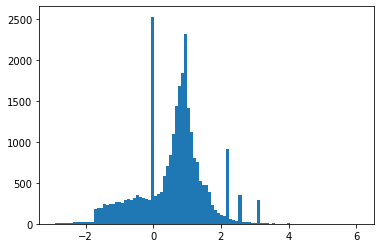

In [11]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

Da bi ova primjer bio relativno kratak, koristi se samo prvih 1000 uzoraka za validaciju i sljedećih 10 000 za obuku:

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

Metode Dataset.skip i Dataset.take to olakšavaju.

Istodobno, metoda Dataset.cache  osigurava da uređaj za učitavanje ne mora ponovno čitati podatke iz datoteke u svakoj epohi:

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [14]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

Ovi skupovi podataka vraćaju pojedinačne primjere. Metoda .batch služi za kreiranje serija odgovarajuće veličine za trening. 


In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

**Prikaz overfittinga**

Najjednostavniji način sprječavanja "overfittinga" je započeti s malim modelom: Model s malim brojem parametara koji se mogu naučiti (koji se određuje brojem slojeva i brojem jedinica po sloju). U dubokom učenju broj parametara koji se mogu naučiti u modelu često se naziva "kapacitetom" modela.


Intuitivno, model s više parametara imat će više "sposobnosti pamćenja" i stoga će biti lako naučiti savršeno mapiranje u obliku rječnika između uzoraka treninga i njihovih ciljeva, mapiranje bez ikakve generalizacijske moći, ali to bi bilo beskorisno pri predviđanju na prethodno nevidljive podatke.


Modeli dubokog učenja obično se dobro uklapaju u podatke o treningu, ali pravi je izazov generalizacija, a ne uklapanje.


S druge strane, ako mreža ima ograničene resurse za pamćenje, mapiranje neće moći lako naučiti. Da bi minimizirao njegov gubitak, morat će naučiti komprimirane reprezentacije koje imaju više prediktivne moći. U isto vrijeme, ako model napravite premalen, teško će se uklopiti u podatke o treningu. Postoji ravnoteža između "prevelikog kapaciteta" i "nedovoljnog kapaciteta".


Nažalost, ne postoji čarobna formula koja bi mogla odrediti pravu veličinu ili arhitekturu vašeg modela (u smislu broja slojeva ili prave veličine za svaki sloj). Morat ćete eksperimentirati koristeći niz različitih arhitektura.


Da biste pronašli odgovarajuću veličinu modela, najbolje je započeti s relativno malo slojeva i parametara, a zatim započnite povećavati veličinu slojeva ili dodavati nove slojeve dok ne vidite smanjene prinose gubitaka od provjere valjanosti.






**Treniranje**

Mnogi modeli treniraju bolje ako postupno smanjujete stopu učenja tijekom treninga. Upotrijebite optimizers.schedules da biste smanjili stopu učenja tijekom vremena:


In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Gornji kod postavlja raspored. InverseTimeDecay za hiperbolično smanjenje stope učenja na 1/2 osnovnog u 1000 epoha, 1/3 na 2000 epoha i tako dalje.


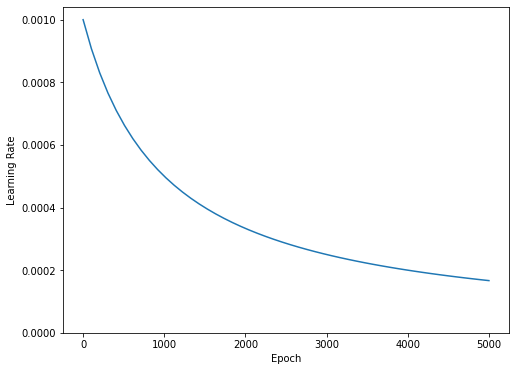

In [17]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Slično će svaki model upotrijebiti iste postavke Model.compile i Model.fit:


In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

**Tiny model**

Treniranje modela

In [0]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [0]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5188,  binary_crossentropy:0.8805,  loss:0.8805,  val_accuracy:0.5140,  val_binary_crossentropy:0.7542,  val_loss:0.7542,  
....................................................................................................
Epoch: 100, accuracy:0.5988,  binary_crossentropy:0.6240,  loss:0.6240,  val_accuracy:0.5960,  val_binary_crossentropy:0.6230,  val_loss:0.6230,  
....................................................................................................
Epoch: 200, accuracy:0.62

Prikaz modela

(0.5, 0.7)

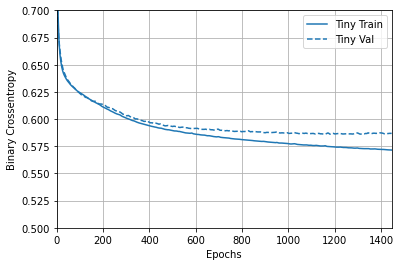

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

**Mali model**


Da bi vidjeli može li pobijediti performanse malog modela, postupno treniramo neke veće modele.

Dva skrivena sloja sa po 16 jedinica:

In [0]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4879,  binary_crossentropy:0.7831,  loss:0.7831,  val_accuracy:0.5150,  val_binary_crossentropy:0.7186,  val_loss:0.7186,  
....................................................................................................
Epoch: 100, accuracy:0.6317,  binary_crossentropy:0.6071,  loss:0.6071,  val_accuracy:0.6250,  val_binary_crossentropy:0.6070,  val_loss:0.

Prikaz modela

(0.5, 0.7)

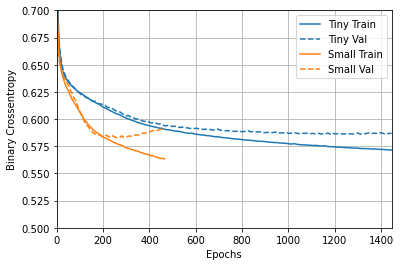

In [26]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

**Srednji model**

3 skrivena sloja sa 64 jedinice svaki:

In [0]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4827,  binary_crossentropy:0.7015,  loss:0.7015,  val_accuracy:0.4620,  val_binary_crossentropy:0.6819,  val_loss:0.6819,  
....................................................................................................
E

Prikaz modela

(0.5, 0.7)

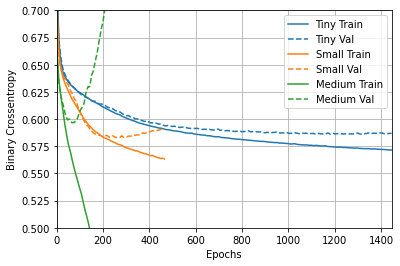

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

**Veliki model**



In [0]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5086,  binary_crossentropy:0.8273,  loss:0.8273,  val_accuracy:0.4800,  val_binary_crossentr

Prikaz modela

(0.5, 0.7)

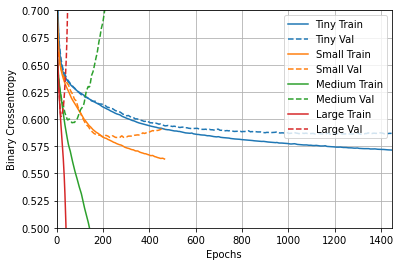

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

**Gubitak**

Čvrste linije prikazuju gubitak treninga, a isprekidane linije prikazuju gubitak od provjere valjanosti  manji gubitak provjere valjanosti ukazuje na bolji model).

Iako izgradnja većeg modela daje mu više snage, ako ta snaga nekako nije ograničena, lako se može prevladati u setu za trening.


U ovom primjeru, obično samo "Tiny" model uspijeva u potpunosti izbjeći overfitting, a svaki od većih modela brže ispunjava podatke.


Normalno je da postoji mala razlika.
Ako se obje metrike kreću u istom smjeru, sve je u redu.
Ako pokazatelj vrednovanja počne stagnirati dok se pokazatelj treninga poboljšava, vjerovatno ste blizu previdljivosti.
Ako metrika provjere valjanosti ide u pogrešnom smjeru, model je očigledno prikladan.


Text(0.5, 0, 'Epochs [Log Scale]')

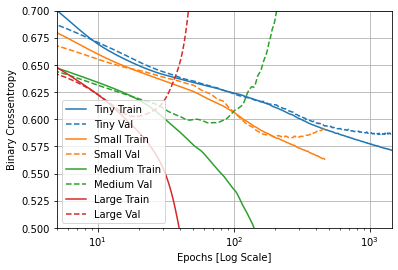

In [33]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Prerano zaustavljanje treninga - jasno da model ne postiže napredak.

**Strategije za sprječavanje overfittinga**

In [34]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpidvb47va/tensorboard_logs/regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

Reguliranje težine L2.


In [36]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5054,  binary_crossentropy:0.8178,  loss:2.3404,  val_accuracy:0.4690,  val_binary_crossentr

l2 (0,001) znači da će svaki koeficijent u matrici težine sloja dodati 0,001 * weight_coefficient_value ** 2 ukupnom gubitku mreže.


Dakle, taj isti "Veliki" model s kaznama za regularizaciju L2 djeluje znatno bolje:


(0.5, 0.7)

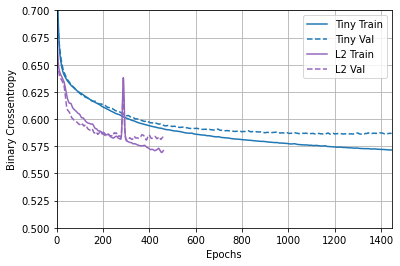

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

"L2" regulirani model sada je mnogo konkurentniji modelu "Tiny". Ovaj "L2" model je također otporniji na prekomjerno opremanje od modela "Veliki" na kojem se temeljio iako ima isti broj parametara.


**Dodavanje "dropouta"**


Dropout je jedna od najučinkovitijih i najčešće korištenih tehnika reguliranja neuronskih mreža koje su razvili Hinton i njegovi studenti na Sveučilištu u Torontu.


Svaki čvor mora objaviti značajke koje su samostalno korisne. "Stopa odustajanja" dio je značajki koje se prigušuju; obično se postavlja između 0,2 i 0,5. U vrijeme ispitivanja, nijedna jedinica ne ispadne, a umjesto toga, izlazne vrijednosti sloja se smanjuju faktorom jednakim stopi pada, tako da se uravnoteži činjenica da je više jedinica aktivno nego u vremenu treninga.





Dodajmo dva sloja otpuštanja u našu mrežu kako bismo vidjeli koliko dobro rade u smanjenju prekomjernog opremljanja:


In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

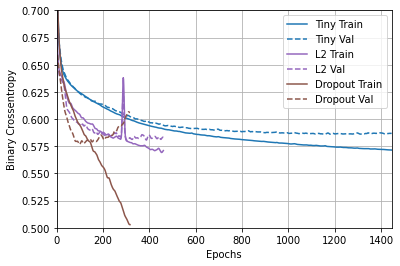

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Iz ovog prikaza je jasno da oba pristupa reguliranja poboljšavaju ponašanje „Velikog“ modela. No, to još uvijek ne nadmašuje čak ni "Tiny" početnu vrijednost.


Testiranje zajedno (Veliki i Tiny model)


In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

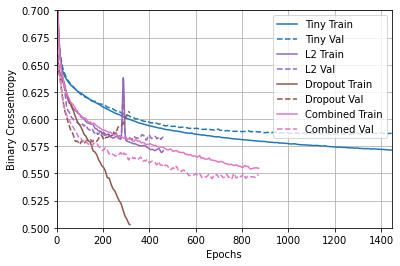

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Ovaj model s "kombiniranom" regularizacijom očito je najbolji do sada.